[70 pts] Task 1: Implementation

•	[60 pts] Implement LDA, Perceptron, and Logistic regression using NumPy only. 

•	[5 pts] Fit the dataset and report the accuracy. Use sklearn.metrics.accuracy_score for the model accuracy calculation. All three models should have an accuracy higher than 80% when the dataset is not trained. 

•	[5 pts] Make visualization of models and verify if models are acceptable. 


imports for entire project

In [250]:
# Load Packages
import numpy as np
np.random.seed(12)
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score 


In [251]:
# loading the data 
df = pd.read_csv("project1_1.csv",header=0)

# preprocessing data

In [252]:
#pre processing the data
df.shape

(100, 4)

In [253]:
df.head()

,Unnamed: 0,X,Y,Class
0,0,0.871319,0.490718,0.0
1,1,0.715472,-0.458668,1.0
2,2,1.462538,-0.386599,1.0
3,3,-0.222521,0.974928,0.0
4,4,0.327699,-0.240278,1.0


In [254]:
df.isnull().sum()

Unnamed: 0    0
X             0
Y             0
Class         0
dtype: int64

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  100 non-null    int64  
 1   X           100 non-null    float64
 2   Y           100 non-null    float64
 3   Class       100 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 3.2 KB


In [256]:
# drop the first column as its just indices
df.drop(columns=['Unnamed: 0'],inplace=True)

# converted the class column to int as its 1 and 0
df['Class'] = (df['Class'].astype(int))
df['Class'] = df['Class'].replace(0,-1)


In [257]:
print(df.duplicated().sum() )

0


# data split and standardization

In [258]:
# standardization using mean and standard deviation 

X = df.drop(columns = ['Class'],axis =1)
y = df['Class']


In [259]:


def train_test_split(*arrays,  train_size=None, test_size=None,random_state=None):
    """Split arrays or matrices into random train and test subsets.
    """
    # Determine the number of input arrays
    n = len(arrays)
    
    # Check that all arrays have the same length
    lengths = [len(arr) for arr in arrays]
    if len(set(lengths)) > 1:
        raise ValueError("All input arrays must have the same length.")
        
    # Determine the number of samples and the size of the training set
    n_samples = lengths[0]
    if test_size is not None:
        train_size = n_samples - int(n_samples * test_size)
    elif train_size is None:
        train_size = int(n_samples * 0.8)
    else :
        train_size = int(n_samples*train_size)
        
    # Generate a random permutation of the sample indices
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.random.permutation(n_samples)
    
    # Split the arrays into training and testing sets
    arrays_train = [arr[indices[:train_size]] for arr in arrays]
    arrays_test = [arr[indices[train_size:]] for arr in arrays]
    
    # Return the training and testing sets as separate arrays
    return arrays_train[0], arrays_test[0], arrays_train[1], arrays_test[1]

In [260]:
X=X.to_numpy()
y=y.to_numpy().reshape(-1,1)

X_train, X_test, y_train, y_test =  train_test_split(X,y,random_state=12,train_size=0.8)

X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)


def scaleData(data,mean,std):
    data_scaled = (data - mean) / std
    return data_scaled
# in this data set the classification has only 2 classes 0 and 1 but doing the scaling just as good practice 
X_train_scaled = scaleData(X_train ,X_mean , X_std)
X_test_scaled = scaleData(X_test ,X_mean , X_std)

# Logistic Regression Model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

When $\lambda = 0$, the model is a regular logistic regression and when $\lambda > 0$, it essentially becomes a regularized logistic regression.

( i had done this code for cs 583 assignment so reusing it )


we will use mini batch gradient descent for the logistic regression model

## Mini-Batch Gradient Descent (MBGD)
Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [261]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: weights: d-by-b matrix
#     xi: data: b-by-d matrix
#     yi: label: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

def mb_objective_gradient(w, xi, yi, lam):
    yx = np.multiply(yi,xi)
    yxw = np.dot(yx,w)
    expTerm1 = np.exp(-yxw)
    logTerm = np.log(1+expTerm1)
    obj = np.mean(logTerm) + (lam/2)*np.sum(w*w)
    expTerm2 = np.exp(yxw)
    g = np.mean( np.divide(-yx,1+expTerm2),axis = 0).reshape(xi.shape[1],1)+lam*w
    return obj,g


1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.

In [262]:
# MBGD for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def mbgd(x, y, lam, learning_rate, w, max_epoch=100, batchsize=10):
    
    objvals = np.zeros(max_epoch)
    n = x.shape[0]
    # epoch loop 
    for i in range(max_epoch):
        # shuffling 
        randomIndices = np.random.permutation(n)
        x_random, y_random = x[randomIndices, :], y[randomIndices, :]
        currentObjValue = 0
        for j in range(0,n,batchsize):
            xi,yi = x_random[j:j+batchsize,:],y_random[j:j+batchsize,:]
            currObj_at_j, gt_at_j = mb_objective_gradient(w,xi,yi,lam)
            w -= learning_rate*gt_at_j
            currentObjValue+= currObj_at_j
        
        learning_rate *= 0.95
        objvals[i]= currentObjValue/(n/batchsize)
        # print(f'Iteration number: {i+1} Current Objective Value: {objvals[i]}')
    return w, objvals
    

# LDA 

The algorithm of LDA can be summarized as follows:

Compute the mean vectors $m_i$ for each class $i$.

Compute the within-class scatter matrix $S_W$ and between-class scatter matrix $S_B$:

$C$ is the number of classes in the labeled dataset

a. $S_W = \sum_{i=1}^C \sum_{x \in D_i} (x - m_i)(x - m_i)^T$

b. $S_B = \sum_{i=1}^C n_i (m_i - m)(m_i - m)^T$, where $m$ is the overall mean and $n_i$ is the number of samples in class $i$.

Solve the generalized eigenvalue problem $S_B w = \lambda S_W w$ to obtain the discriminant vectors $w_1, w_2, ..., w_{C-1}$.

Sort the discriminant vectors by their corresponding eigenvalues in decreasing order.

Select the $k$ most significant discriminant vectors, where $k \leq C-1$.

Project the data onto the subspace spanned by the selected discriminant vectors.

Train a classifier using the transformed data.

Use the classifier to predict the class labels of new instances.

In [263]:
def LDA(X,y):
    class_means = []
    #compute means vectors withing each class c 
    for c in np.unique(y):
        X_c = X[y == c]
        class_means.append(np.mean(X_c, axis=0))
    # Compute within-class scatter matrix
    S_w = np.zeros((X.shape[1], X.shape[1]))
    for c, class_mean in zip(np.unique(y), class_means):
        X_c = X[y == c]
        diff = X_c - class_mean
        S_w += np.dot(diff.T, diff)
    
    # Compute between-class scatter matrix
    overall_mean = np.mean(X, axis=0)
    S_b = np.zeros((X.shape[1], X.shape[1]))
    for c, class_mean in zip(np.unique(y), class_means):
        n = X[y == c].shape[0]
        diff = class_mean - overall_mean
        S_b += n * np.dot(diff.reshape(-1, 1), diff.reshape(1, -1))
    
    # Compute eigenvectors and eigenvalues of S_w^(-1) S_b
    eig_vals, eig_vecs = np.linalg.eig(np.dot(np.linalg.inv(S_w), S_b))
    
    # Select the eigenvector with the largest eigenvalue as the projection direction
    w = eig_vecs[:, np.argmax(eig_vals)]
    
    # Transform the samples onto the new subspace
    X_lda = np.dot(X, w)
    
    return w, X_lda



# Perceptron

In [264]:
def perceptron(features, labels, learning_rate=0.01, num_epochs=1000):
    n_samples, n_features = features.shape
    
    # Initialize weights and bias to zeros
    weights = np.zeros(n_features)
    bias = 0
        
    # Iterate over epochs
    for _ in range(num_epochs):
        # Iterate over training examples
        for i in range(n_samples):
            # Compute weighted sum of inputs and bias
            z = np.dot(weights, features[i]) + bias
                
            # Apply step function to get predicted class
            y_pred = np.where(z > 0, 1, 0)
                
            # Update weights and bias if prediction is incorrect
            if y_pred != labels[i]:
                weights += learning_rate * (labels[i] - y_pred) * features[i]
                bias += learning_rate * (labels[i] - y_pred)
    
    return weights, bias

# training

In [265]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
lam = 0
learning_rate = 1
X_train_scaled_with_bias = np.hstack([X_train_scaled, np.ones((X_train_scaled.shape[0], 1))])
w = np.zeros((X_train_scaled_with_bias.shape[1],1))
w_mbgd, objvals_mbgd = mbgd(X_train_scaled_with_bias, y_train, lam, learning_rate, w,10)

In [266]:
# train LDA 
w_lda, X_lda = LDA(X_train_scaled,y_train.ravel())

In [267]:
w_perceptron, bias_perceptron = perceptron(X_train_scaled, y_train, learning_rate=0.01, num_epochs=1000)

# 5. Prediction
### Compare the training and testing accuracy for logistic regression and regularized logistic regression.

In [268]:
# Predict class label
# Inputs:
#     w: weights: d-by-1 matrix
#     X: data: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    f = np.sign(np.dot(X,w))
    return np.asarray(f)

In [269]:

# Logistic regression 
f_mbgd_train = predict(w_mbgd, X_train_scaled_with_bias)
f_mbgd_train=f_mbgd_train.astype(int)
accuracy_score_mbgd_train = accuracy_score(y_train,f_mbgd_train)
print('accuracy score for Logistic regression training is : ',accuracy_score_mbgd_train)
print('Training classification error for Logistic regression training is ' , 1-accuracy_score_mbgd_train)


X_test_scaled_with_bias = np.hstack([X_test_scaled, np.ones((X_test_scaled.shape[0], 1))])
f_mbgd_test = predict(w_mbgd, X_test_scaled_with_bias)
f_mbgd_test=f_mbgd_test.astype(int)
accuracy_score_mbgd_test = accuracy_score(y_test,f_mbgd_test)
print('accuracy score for Logistic regression test data is : ',accuracy_score_mbgd_test)
print('Training classification error for Logistic regression test data is ' , 1-accuracy_score_mbgd_test)


accuracy score for Logistic regression training is :  0.8875
Training classification error for Logistic regression training is  0.11250000000000004
accuracy score for Logistic regression test data is :  0.8
Training classification error for Logistic regression test data is  0.19999999999999996


In [270]:
# LDA
f_lda_train = predict(w_lda, X_train_scaled)
f_lda_train=f_lda_train.astype(int)
accuracy_score_lda_train = accuracy_score(y_train,f_lda_train)
print('accuracy score for lda training is : ',accuracy_score_lda_train)
print('Training classification error for lda training is ' , 1-accuracy_score_lda_train)

f_lda_test = predict(w_lda, X_test_scaled)
f_lda_test=f_lda_test.astype(int)
accuracy_score_lda_test = accuracy_score(y_test,f_lda_test)
print('accuracy score for lda  test data is : ',accuracy_score_lda_test)
print('Training classification error for lda test data is ' , 1-accuracy_score_lda_test)

accuracy score for lda training is :  0.8875
Training classification error for lda training is  0.11250000000000004
accuracy score for lda  test data is :  0.8
Training classification error for lda test data is  0.19999999999999996


In [271]:
# perceptron
f_perceptron_train = predict(w_perceptron, X_train_scaled)
f_perceptron_train=f_perceptron_train.astype(int)
accuracy_score_perceptron_train = accuracy_score(y_train,f_perceptron_train)
print('accuracy score for perceptron training is : ',accuracy_score_perceptron_train)
print('Training classification error for perceptron training is ' , 1-accuracy_score_perceptron_train)

weights_and_bias_perceptron = np.hstack([w_perceptron, bias_perceptron])
f_perceptron_test = predict(weights_and_bias_perceptron, X_test_scaled_with_bias)
f_perceptron_test=f_perceptron_test.astype(int)
accuracy_score_perceptron_test = accuracy_score(y_test,f_perceptron_test)
print('accuracy score for perceptron  test data is : ',accuracy_score_perceptron_test)
print('Training classification error for perceptron test data is ' , 1-accuracy_score_perceptron_test)

accuracy score for perceptron training is :  0.875
Training classification error for perceptron training is  0.125
accuracy score for perceptron  test data is :  0.75
Training classification error for perceptron test data is  0.25


# Graphs

In [272]:
#descaling data for graph plots

f_mbgd_train=f_mbgd_train.astype(int)

f_lda_train=f_lda_train.astype(int)

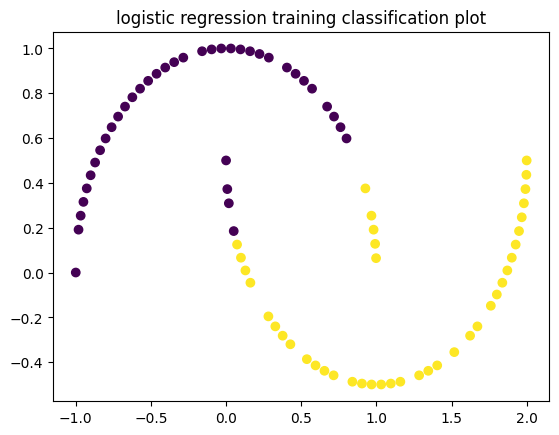

In [273]:
plt.scatter(X_train[:, 0], X_train[:, 1],  c=f_mbgd_train, cmap='viridis')
plt.title('logistic regression training classification plot')
plt.show()


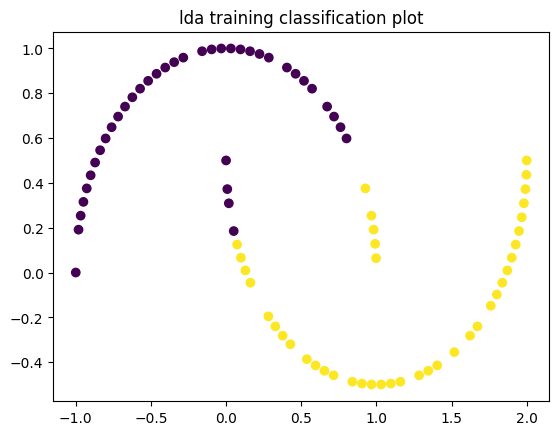

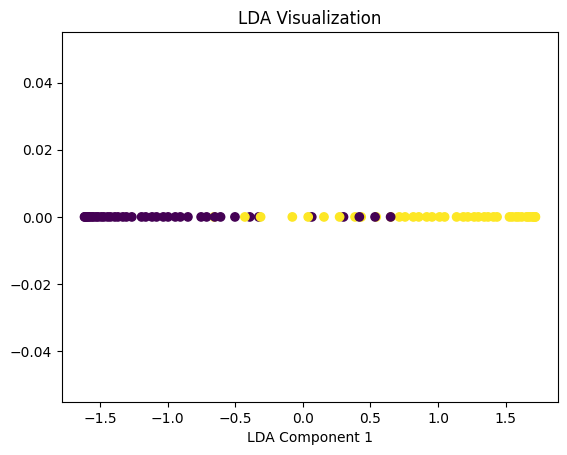

In [274]:

plt.scatter(X_train[:, 0], X_train[:, 1], c=f_lda_train, cmap='viridis')
plt.title('lda training classification plot')
plt.show()

plt.scatter(X_lda, np.zeros(X_lda.shape), c=y_train, cmap='viridis')
plt.xlabel('LDA Component 1')
plt.title('LDA Visualization')
plt.show()